> SVM

libsvm 库直接用吧。

# load data

In [1]:
# iris 前100行(2类)，前2列
import numpy as np
import pandas as pd
def loadDataSet():
    dt=pd.read_csv('../data/iris_data/iris.csv', index_col=0)
    return dt.iloc[0:100,:]
iris=loadDataSet()
print(iris.shape) #100 5
print(iris.head())
iris.tail()

(100, 5)
   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
1           5.1          3.5           1.4          0.2  setosa
2           4.9          3.0           1.4          0.2  setosa
3           4.7          3.2           1.3          0.2  setosa
4           4.6          3.1           1.5          0.2  setosa
5           5.0          3.6           1.4          0.2  setosa


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
96,5.7,3.0,4.2,1.2,versicolor
97,5.7,2.9,4.2,1.3,versicolor
98,6.2,2.9,4.3,1.3,versicolor
99,5.1,2.5,3.0,1.1,versicolor
100,5.7,2.8,4.1,1.3,versicolor


In [2]:
colors=[]
for item in iris['Species']:
    if item=='setosa':
        colors.append('red')
    else:
        colors.append('orange')
import matplotlib.pyplot as plt
plt.scatter(iris['Sepal.Length'], iris['Sepal.Width'], color=colors )
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
# 标签要数字化
def np2Array(npArr):
    arr=[]
    tags=[]
    for i in range(npArr.shape[0]):
        arr.append([npArr.iloc[i,0], npArr.iloc[i,1]])
        if "setosa"==npArr.iloc[i,-1]:
            tags.append(-1.0)
        else:
            tags.append(1.0)
    return arr,tags
dataArr, dataTags=np2Array(iris)

print(dataArr[0:10])
dataTags[0:10] #标签使用1和-1

[[5.1, 3.5], [4.9, 3.0], [4.7, 3.2], [4.6, 3.1], [5.0, 3.6], [5.4, 3.9], [4.6, 3.4], [5.0, 3.4], [4.4, 2.9], [4.9, 3.1]]


[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

# 简易版SMO算法

## 辅助函数

In [4]:
# 获取0-m之间，和i不等的一个随机整数
import random
def selectJrand(i, m):
    j=i
    while j==i:
        j=int(random.uniform(0,m))
    return j
# test
selectJrand(50, 100)

37

In [5]:
# 矫正alpha值，位于H和L之间
def clipAlpha(alpha, H, L):
    if alpha>H:
        alpha=H
    if alpha<L:
        alpha=L
    return alpha
# test
clipAlpha(10, 200, 100)

100

## 简化版SMO算法

> 简化版的SMO算法运行很慢

### 怎么预测一个点的分类？

f(x)=wT.x+b=求和(i=1,n aiyixi)T*x+b    ------>       (1)

In [6]:
dataMatrix=np.mat(dataArr) #输入数据m行2列
labelMat=np.mat(dataTags).transpose() #输入数据的标签，转置后 1列m行. 列向量

b=0 #截距初始值
m,n=np.shape(dataMatrix) #m行 n列
alphas=np.mat(np.zeros((m, 1))) #初始化alpha值，m行1列的0矩阵  
# --> 可以尝试 np.ones(),底下2种矩阵算法结果一样

In [7]:
i=2
print(np.multiply(alphas, labelMat).T . shape) #1x100
print((dataMatrix*dataMatrix[i, :].T).shape) #100x1

# 矩阵算法1: 按公式(1)
pred=(np.multiply(alphas, labelMat).T * dataMatrix) * dataMatrix[i, :].T +b
print('Pred=', pred, pred.tolist()[0][0])

# 矩阵算法2: 代码中使用的方法是后两者结合，这样不用矩阵嵌套成[[0.]]了，形式上更好。
# 由于向量乘法满足结合律，所以怎么计算都行
fXi=float(np.multiply(alphas, labelMat).T * (dataMatrix*dataMatrix[i, :].T)) +b
print('fXi',fXi) #0

(1, 100)
(100, 1)
Pred= [[0.]] 0.0
fXi 0.0


### smoSimple()函数的实现

In [29]:
import numpy as np
def smoSimple(dataMatIn, classLabels, C,toler, maxIter, debug=False):
    dataMatrix=np.mat(dataMatIn) #输入数据m行2列
    labelMat=np.mat(classLabels).transpose() #输入数据的标签，转置后 1列m行. 列向量
    
    b=0 #截距初始值
    m,n=np.shape(dataMatrix) #m行 n列
    alphas=np.mat(np.zeros((m, 1))) #初始化alpha值，m行1列的0矩阵
    
    if debug:print('数据维度: ',dataMatrix.shape, labelMat.shape, alphas.shape)
    
    iter2=0 # 没有任何alpha值改变的情况下，循环的次数
    while iter2<maxIter:
        alphaPairsChanged=0 #循环前，重置alpha更新次数计数器: 0次
        for i in range(m): #每一个点
            # 预测值fXi，预测已知点i的分类
            fXi=float(np.multiply(alphas, labelMat).T * (dataMatrix*dataMatrix[i, :].T)) +b
            # 预测相对于实际的差异
            Ei=fXi - float(labelMat[i])
            # 如果alpha可以更改，则进入优化过程
            if ((labelMat[i]*Ei < -toler) and (alphas[i]<C) ) or \
                ((labelMat[i]*Ei > toler) and (alphas[i]>0)):  ## 最开始的alpha都是0，怎么进入if的?
                    #知道了，都是用上一个条件<C进入的
                    # 而之后，一旦alpha小于0或者大于C，会被调整为0或C。而一旦碰到这两个边界，就不会进入if，不会被继续优化。
                    
                j = selectJrand(i, m) #随机选择第二个alpha一起调整，j!=i
                # 预测j点分类
                fXj=float(np.multiply(alphas, labelMat).T * (dataMatrix*dataMatrix[j,:].T))+b
                # 预测相对于实际的差异
                Ej=fXj-float(labelMat[j])
                
                # 记录i和j点旧的alpha
                alphaIold=alphas[i].copy();
                alphaJold=alphas[j].copy();
                
                
                # 保证alpha在0到C之间  //------------------------------------------>>>>>todo??
                # 为什么这样调整？是下文决定的吗？
                if (labelMat[i] != labelMat[j]):  #(1)如果训练样本的标签类别不同
                    L=max(0, alphas[j]-alphas[i])   # 最小值，
                    H=min(C, C+alphas[j]-alphas[i]) # 最大值，
                else:                             #(2) 如果训练样本i和j同类
                    L=max(0, alphas[j]+alphas[i]-C)  #
                    H=min(C, alphas[j]+alphas[i])
                
                # 如果L==H，无法调整，下一个数据点
                if L==H:
                    if debug:print( "L==H")
                    continue;
                
                
                ########################
                # eta是优化变量 eta=-(xi-xj)^2=2*xi*xj - xi^2 * xj^2 <=0， 
                ########################
                eta=2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - \
                    dataMatrix[i, :]*dataMatrix[i,:].T - \
                    dataMatrix[j, :]*dataMatrix[j,:].T
                if eta==0: # 当eta==0时，不好优化；先跳过去
                    if debug:print('eta==0')
                    continue;
                
                # 然后改变alphaj, 该变量是: input*delta*缩放系数
                alphas[j] -= labelMat[j]*(Ei-Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L) # 对alphaj进行调整
                if (abs(alphas[j]-alphaJold)<0.000001): #如果alphaj基本和原来基本没有变化，则继续下一个点
                    if debug:print("j not moving enough")
                    alphas[j]=alphaJold #恢复alphaj为原样
                    continue;
                    
                # 然后如果alphaj变动比较大，则同时变动alphai: 大小相同，符号相反
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold-alphas[j])
                
                
                # 这个是干啥的？
                #########################
                # 矫正 b 的，没看懂原理
                #########################
                b1=b-Ei-labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[i,:].T-\
                        labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i, :]*dataMatrix[j,:].T
                b2=b-Ej-labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[j,:].T-\
                        labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j, :]*dataMatrix[j,:].T
                # 
                if (0<alphas[i]) and (alphas[i]<C):
                    b=b1
                elif (0<alphas[j]) and (alphas[j]<C):
                    b=b2
                else:
                    b=(b1+b2)/2.0
                
                # 执行到这里，说明程序更新了alphai和j
                alphaPairsChanged += 1
                if debug:print("iter: %d i:%d, pairs changed %d" % (iter2, i, alphaPairsChanged))
        # 如果没有更新，则迭代次数递增1，当持续空迭代max次后，循环结束
        if alphaPairsChanged==0:
            iter2 += 1
        else:
            iter2=0 #如果更新过alpha，则让迭代次数归零。
        if debug:print(">>> iteration number: %d" % iter2)
    return b.tolist()[0][0], alphas
# test
#smoSimple(dataMatIn, classLabels, C,toler, maxIter)
random.seed(2020)
np.random.seed(2020)
b, alphas=smoSimple(dataArr, dataTags, C=200, toler=0.00001, maxIter=20)
# C=100挺好的，10也行

In [30]:
print(b)
alphas[alphas>0]

-17.07606941387632


matrix([[2.77555756e-16, 4.44089210e-16, 5.55111512e-17, 1.55376758e+01,
         1.72409811e+01, 1.56054000e+01, 2.77555756e-16, 1.71732568e+01]])

### 获得支持向量

In [31]:
def getSupportVec(alphas):
    setNeg=[]
    setPos=[]
    for i in range(100):
        if alphas[i]>0:
            #print(dataArr[i], dataTags[i])
            if dataTags[i]>0:
                setPos.append(dataArr[i])
            else:
                setNeg.append(dataArr[i])
    return setPos, setNeg
# test
setPos,setNeg=getSupportVec(alphas)
print(setPos)
setNeg

[[4.9, 2.4], [5.6, 2.9], [5.4, 3.0]]


[[4.9, 3.1], [5.4, 3.7], [4.9, 3.1], [5.5, 3.5], [4.5, 2.3]]

> 事实上，所有非支持向量的系数alphai=0.

> f(x)=wT.x+b=求和(i=1,n, ai*yi*xi)T*x+b

获取支持向量后，之后对未知数据点的预测只是用支持向量(其他点的系数alphai都是0)。

对于一个新向量，计算它与支持向量的内积即可，大部分训练向量不再需要，从而大大加快了分类速度。

这也是支持向量机的名字的由来。这也是SVM后续使用 核函数 进行非线性推广的基本前提。

### 获取超平面w，并可视化

w=alphas*y*x

np.mat(dataArr).shape #(100, 2)

np.multiply(alphas.T, np.mat(dataTags) ).shape #(1, 100)

In [32]:
# get w
def getW(alphas, dataArr, dataTags):
    w=np.multiply(np.mat(alphas).T, np.mat(dataTags))*np.mat(dataArr)
    w2=w.tolist()[0]
    return w2
#test
w=getW(alphas, dataArr, dataTags)
w

[6.160415360845888, -5.063391178230496]

[6.160415360845888, -5.063391178230496] -17.07606941387632


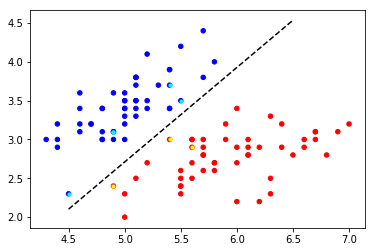

In [33]:
# plot line and dot
def plot2(w,b):
    print(w,b)
    colors=[]
    for item in iris['Species']:
        if item=='setosa':
            colors.append('blue')
        else:
            colors.append('red')
    import matplotlib.pyplot as plt
    plt.scatter(iris['Sepal.Length'], iris['Sepal.Width'], color=colors,s=20 )
    
    # 画出支持向量点
    setPos,setNeg=getSupportVec(alphas)
    def getXY(pos):
        x=[];y=[]
        for i in range(len(pos)):
            p=pos[i]
            x.append(p[0])
            y.append(p[1])
        return x,y
    X,Y=getXY(setPos)
    plt.scatter(X,Y, color="yellow", s=10)
    X,Y=getXY(setNeg)
    plt.scatter(X,Y, color="cyan", s=10)
    
    # 分割线
    x=np.linspace(4.5, 6.5, 100)
    y=(-b-w[0]*x)/w[1]
    plt.plot(x,y, 'k--')
    # 
    
    plt.show()
# test
plot2(w,b)

> 上图可见，用的C过大，导致过拟合了：支持向量不都是距离分割线最近的点了。

### 使用模型：预测一个未知点的类别

In [34]:
# f(x)=w^T.x+b

print(iris.iloc[0:3,:])
iris.iloc[95:99,:]

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
1           5.1          3.5           1.4          0.2  setosa
2           4.9          3.0           1.4          0.2  setosa
3           4.7          3.2           1.3          0.2  setosa


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
96,5.7,3.0,4.2,1.2,versicolor
97,5.7,2.9,4.2,1.3,versicolor
98,6.2,2.9,4.3,1.3,versicolor
99,5.1,2.5,3.0,1.1,versicolor


In [35]:
print(w,b)

[6.160415360845888, -5.063391178230496] -17.07606941387632


In [36]:
def clisifySVM(x, w,b):
    rs=np.mat(w)*np.mat(x).T+b
    rs.tolist()[0][0]
    print(rs)
    if rs<=0:
        return 'setosa'
    else:
        return "versicolor"
# test
clisifySVM([5.1,3.5 ],w,b)

[[-3.3798202]]


'setosa'

In [37]:
clisifySVM([5.7,3.0],w,b)

[[2.84812461]]


'versicolor'

## 松弛变量C (slack variable): 错判罚分

如果数据不是完全线性可分的，也就是怎么划分，都会有少量点是错判的，怎么办？

引入惩罚函数，就是这个点到其正确位置的距离。

> The C parameter allows you to decide how much you want to penalize misclassified points.

> 常数C是为了平衡“最大化间隔”和“保证大部分店的函数间隔小于1.0”这两个目标的权重。

low C: prioritize simplicity(soft margin) 分错的点多

high C: prioritize making few mistakes.分错的点少，但是过拟合的情况比较严重。

怎么选合适的C参数呢？反复尝试，做k-C.V曲线、可视化。

### large C=20，错判点少

In [38]:
b, alphas=smoSimple(dataArr, dataTags, C=20, toler=0.00001, maxIter=40)
# C=100挺好的，10也行
print(b)

-17.210272150254823


[6.279404189743104, -5.232836824785984] -17.210272150254823


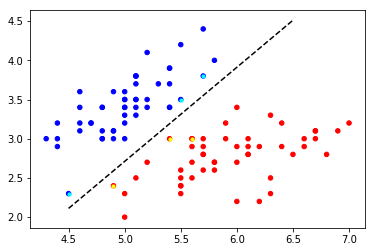

In [39]:
w=getW(alphas, dataArr, dataTags)
plot2(w,b)

### too small C=0.02，错判点多

In [40]:
b, alphas=smoSimple(dataArr, dataTags, C=0.20, toler=0.00001, maxIter=40)
# C=100挺好的，10也行
print(b)

-3.6153604047425514


[1.5384597744803385, -1.5384655074192572] -3.6153604047425514


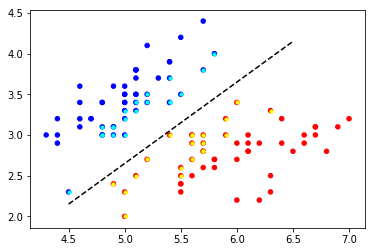

In [41]:
w=getW(alphas, dataArr, dataTags)
plot2(w,b)

### 耗时分析

In [46]:
import time
start=time.time()
penalty=0.20
for i in range(20):
    b, alphas=smoSimple(dataArr, dataTags, C=penalty, toler=0.00001, maxIter=40)
    w=getW(alphas, dataArr, dataTags)
    print('>>', i,penalty, w,b, round(time.time()-start,2), "seconds elapsed;" )
    #
    penalty += 0.50
# about 40 seconds;

>> 0 0.2 [1.538467767765654, -1.5384615384615223] -3.6154157619052163 1.19 seconds elapsed;
>> 1 0.7 [2.222227805329583, -2.222221524333753] -5.000035173576563 2.15 seconds elapsed;
>> 2 1.2 [2.339046760620678, -2.6180215818249373] -4.3840845246030495 3.66 seconds elapsed;
>> 3 1.7 [2.8285814429769953, -2.8535726803720944] -6.279338039554916 5.58 seconds elapsed;
>> 4 2.2 [2.883792696938934, -2.883792696938833] -6.497861012041542 6.85 seconds elapsed;
>> 5 2.7 [3.2400000000000735, -3.23999999999992] -7.424000000000657 8.41 seconds elapsed;
>> 6 3.2 [3.333322749369852, -3.333322749369921] -7.666639148361408 9.94 seconds elapsed;
>> 7 3.7 [3.3333472726458973, -3.3333472726464026] -7.666694545290042 11.95 seconds elapsed;
>> 8 4.2 [3.3333407100527204, -3.3333296449739596] -7.666719041373324 15.6 seconds elapsed;
>> 9 4.7 [3.319529203400575, -3.3402353982998667] -7.568657344143611 17.59 seconds elapsed;
>> 10 5.2 [3.3469968408410757, -3.3469968408412463] -7.69399368168167 20.56 seconds ela

# 更完整的SMO算法实现：更快

> 完整版的改进是，选择alpha的方式，应用了一些能提速的启发方法。

## 用于清理代码的数据结构

In [274]:
import numpy as np

class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X=dataMatIn
        self.labelMat=classLabels
        self.C=C
        self.tol=toler
        self.m=np.shape(dataMatIn)[0]
        self.alphas=np.mat(np.zeros((self.m, 1)))
        self.b=0
        self.eCache=np.mat( np.zeros( (self.m,2) ) ) # 误差缓存
        # 第一列，是eCache是否有效的标志位
        # 第二列，是实际的E值

# 计算Error值，并返回
def calcEk(oS, k):
    fXk=float(np.multiply(oS.alphas, oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b
    Ek=fXk-float(oS.labelMat[k])
    return Ek

# 循环中的启发式方法,求 max(|Ei-Ej|)的j
def selectJ(i, oS, Ei):
    maxK=-1;  maxDeltaE=0; Ej=0;
    oS.eCache[i]=[1, Ei] #第一位设置为可用1，
    validEcacheList=np.nonzero(oS.eCache[:,0].A)[0] #构建了一个非零表

    # 
    if len(validEcacheList)>1: 
        for k in validEcacheList: #选择改变最大的那个j
            if k==i: continue;
            Ek=calcEk(oS, k)
            deltaE=abs(Ei-Ek)
            if deltaE>maxDeltaE:
                maxK=k; maxDeltaE=deltaE; Ej=Ek; # 选择具有最大步长的j
        return maxK, Ej
    else:
        j=selectJrand(i, oS.m) # 如果是第一个，就随机选择一个
        Ej=calcEk(oS, j)
        return j, Ej

def updateEk(oS, k):
    Ek=calcEk(oS, k)
    oS.eCache[k]=[1, Ek]

In [276]:
# 代码解释
A0=np.mat([[0,10], [1,50], [28,0] ])
print(A0)

B1=np.nonzero(A0[:,0])[0] #第一列，非零的行号
B1

[[ 0 10]
 [ 1 50]
 [28  0]]


array([1, 2], dtype=int64)

In [277]:
A0[B1]

matrix([[ 1, 50],
        [28,  0]])

## 完整的Platt SMO 算法中的优化过程

In [317]:
# 内循环
# 重要更新：
#1. 使用了数据结构，在参数oS中传递
#2. 使用selectJ()而不是selectJrand()来选择第二个要更新的alpha的值

def innerL(i, oS, debug=False):
    Ei=calcEk(oS, i)
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i]<oS.C)) or \
       ((oS.labelMat[i] * Ei >  oS.tol) and (oS.alphas[i] > 0)):
        #
        j, Ej=selectJ(i, oS, Ei)
        alphaIold=oS.alphas[i].copy()
        alphaJold=oS.alphas[j].copy()
        # 设置最大最小值
        if (oS.labelMat[i] != oS.labelMat[j]):
            L=max(0, oS.alphas[j]-oS.alphas[i])
            H=min(oS.C, oS.C+oS.alphas[j]-oS.alphas[i])
        else:
            L=max(0, oS.alphas[j]+oS.alphas[i]-oS.C)
            H=min(oS.C, oS.alphas[j]+oS.alphas[i])
        #
        if L==H:
            if debug:print('L==H');
            return 0
        
        
        #########################
        # 重点优化对象 eta ------------>> //todo 没看懂
        #########################
        eta=2.0*oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta==0:
            if debug:print("Eta==0")
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei-Ej)/eta
        oS.alphas[j]=clipAlpha(oS.alphas[j], H, L)
        
        # 更新误差缓存
        updateEk(oS, j)
        
        # 如果alpha j变动太小，则忽略
        if abs(oS.alphas[j]-alphaJold)<0.00001:
            if debug:print("j not moving enough")
            #oS.alphas[j]=-alphaJold
            return 0


        
        # alpha i 变动和 alpha j相同，方向相反
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        updateEk(oS, i)
        
        
        #########################
        # 更新b   //todo -----> 这一步也没看懂
        #########################
        b1=oS.b-Ei-oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T-\
                        oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2=oS.b-Ej-oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T-\
                        oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        # 
        if (0<oS.alphas[i]) and (oS.alphas[i]<oS.C):
            oS.b=b1
        elif (0<oS.alphas[j]) and (oS.alphas[j]<oS.C):
            oS.b=b2
        else:
            oS.b=(b1+b2)/2.0
        
        return 1
    else:
        return 0;
#

In [333]:
# 外循环
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin',0), debug=False):
    oS=optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler)
    iter2=0
    entireSet=True
    alphaPairsChanged=0
    
    #停止条件: 达到最大遍历数，或者刚遍历全局且没有可以调整的。
    while (iter2<maxIter) and  ((alphaPairsChanged>0) or (entireSet)):
        alphaPairsChanged=0
        if entireSet: #遍历所有的值
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
                if debug:print(">>fullSet, iter:%d i:%d, pairs changed:%d" % (iter2, i, alphaPairsChanged))
            iter2 += 1
        else: # 遍历非边界值
            nonBoundIs=np.nonzero((oS.alphas.A>0) * (oS.alphas.A<C))[0]
            
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                if debug:print(">>non-bound, iter:%d i:%d, pairs changed:%d" % (iter2, i, alphaPairsChanged))
            # 遍历计数器
            iter2 += 1
            
        # 什么情况下切换两种遍历模式呢？
        if entireSet: #如果刚全局遍历过，就切换到 非边界遍历
            entireSet = False
        elif alphaPairsChanged==0: # 没有变动，则切换为 全局遍历
            entireSet=True
        #
        if debug:print(">>>> iteration number: %d" % iter2)
    return oS.b, oS.alphas
# test
b,alphas=smoP(dataArr, dataTags, C=20, toler=0.000001, maxIter=40, debug=True)

print(b,alphas.shape)
alphas[alphas>0]

>>fullSet, iter:0 i:0, pairs changed:1
>>fullSet, iter:0 i:1, pairs changed:2
>>fullSet, iter:0 i:2, pairs changed:2
>>fullSet, iter:0 i:3, pairs changed:2
>>fullSet, iter:0 i:4, pairs changed:2
>>fullSet, iter:0 i:5, pairs changed:3
>>fullSet, iter:0 i:6, pairs changed:3
>>fullSet, iter:0 i:7, pairs changed:3
>>fullSet, iter:0 i:8, pairs changed:3
>>fullSet, iter:0 i:9, pairs changed:3
>>fullSet, iter:0 i:10, pairs changed:4
>>fullSet, iter:0 i:11, pairs changed:4
>>fullSet, iter:0 i:12, pairs changed:4
>>fullSet, iter:0 i:13, pairs changed:4
>>fullSet, iter:0 i:14, pairs changed:4
>>fullSet, iter:0 i:15, pairs changed:4
>>fullSet, iter:0 i:16, pairs changed:4
>>fullSet, iter:0 i:17, pairs changed:4
>>fullSet, iter:0 i:18, pairs changed:4
>>fullSet, iter:0 i:19, pairs changed:4
>>fullSet, iter:0 i:20, pairs changed:4
>>fullSet, iter:0 i:21, pairs changed:4
>>fullSet, iter:0 i:22, pairs changed:4
>>fullSet, iter:0 i:23, pairs changed:4
>>fullSet, iter:0 i:24, pairs changed:4
>>fullSet,

matrix([[5.2783044 , 0.18309429, 1.40582145, 0.70055721, 0.44557183,
         5.06314478, 0.49854975, 3.488837  , 2.72539722, 5.13665082,
         0.78148735, 0.44557183]])

In [313]:
def test():
    a=np.mat([12,3,4,0,0,20]).T
    print(a)
    #print(a.A, a.A>10, a.A<10)
    #print(a, a>10, a<10)
    c=np.nonzero((a.A>0) * (a.A<10))[0]
    print(c)
    #return a[c]
test()

[[12]
 [ 3]
 [ 4]
 [ 0]
 [ 0]
 [20]]
[1 2]


### 获取w

[[ 3.79273006]
 [-2.55347617]] -12.194290086266923


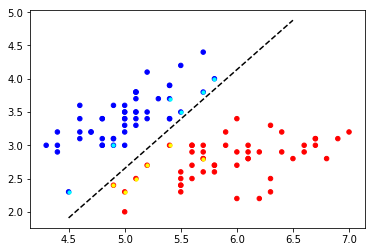

In [334]:
def calcWs(alphas, dataArr, classLabels):
    X=np.mat(dataArr);
    labelMat=np.mat(classLabels).transpose()
    m,n=np.shape(X)
    w=np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i], X[i,:].T)
    return w
# test
ws=calcWs(alphas, dataArr, dataTags)
#print(ws)

plot2(ws,b.tolist()[0][0])

In [215]:
# 之前的函数计算w:
getW(alphas, dataArr, dataTags)

[13.57105237405381, -8.235424235970662]

### 不同的C的结果很不稳定

貌似: 训练策略不同，C的范围也不同。
    
完整方法C在20-40时效果较好。

In [ ]:
Cs=20
for i in range(20):
    Cs+=1
    b,alphas=smoP(dataArr, dataTags, C=Cs, toler=0.001, maxIter=40)
    ws=calcWs(alphas, dataArr, dataTags)
    plot2(ws,b.tolist()[0][0])
    print(i,'>>C=',Cs, '; b=',b, '; w=',ws.T, '\n', "="*20,'\n')

### 对新的结果判别

In [335]:
print(iris.head())

iris.iloc[96:99,:]

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
1           5.1          3.5           1.4          0.2  setosa
2           4.9          3.0           1.4          0.2  setosa
3           4.7          3.2           1.3          0.2  setosa
4           4.6          3.1           1.5          0.2  setosa
5           5.0          3.6           1.4          0.2  setosa


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
97,5.7,2.9,4.2,1.3,versicolor
98,6.2,2.9,4.3,1.3,versicolor
99,5.1,2.5,3.0,1.1,versicolor


In [336]:
ws.T*np.mat([4.9,3.0]).T+b

matrix([[-1.2703413]])

In [337]:
np.mat([6.2, 2.9])*ws+b

matrix([[3.9155554]])

### 耗时分析

In [338]:
import time
start=time.time()
penalty=20
for i in range(20):
    b, alphas=smoP(dataArr, dataTags, C=penalty, toler=0.00001, maxIter=40)
    w=getW(alphas, dataArr, dataTags)
    print('>>', i,penalty, w,b, round(time.time()-start,2), "seconds elapsed;" )
    #
    penalty += 0.50
# about 40 seconds;

>> 0 20 [2.866833421198237, -2.385355763560696] [[-8.41443214]] 0.1 seconds elapsed;
>> 1 20.5 [2.866833421198237, -2.385355763560696] [[-8.41443214]] 0.23 seconds elapsed;
>> 2 21.0 [2.866833421198237, -2.385355763560696] [[-8.41443214]] 0.32 seconds elapsed;
>> 3 21.5 [3.462566376203945, -3.1976935866147507] [[-8.29211064]] 0.41 seconds elapsed;
>> 4 22.0 [2.866833421198237, -2.385355763560696] [[-8.41443214]] 0.5 seconds elapsed;
>> 5 22.5 [2.2181317538873966, -2.4605003693178666] [[-5.32244204]] 0.87 seconds elapsed;
>> 6 23.0 [2.866833421198237, -2.385355763560696] [[-8.41443214]] 0.97 seconds elapsed;
>> 7 23.5 [2.866833421198237, -2.385355763560696] [[-8.41443214]] 1.07 seconds elapsed;
>> 8 24.0 [4.551956792225347, -3.7607715576328076] [[-12.87306191]] 1.17 seconds elapsed;
>> 9 24.5 [2.866833421198237, -2.385355763560696] [[-8.41443214]] 1.34 seconds elapsed;
>> 10 25.0 [2.866833421198237, -2.385355763560696] [[-8.41443214]] 1.43 seconds elapsed;
>> 11 25.5 [2.866833421198237,

> 简化版 40.33s vs 完整版 2.79s, 确实速度够快。

# 核函数 kernel trick

> 将内积替换为核函数的方式成为核技巧(kernel trick)

例子: 径向基核函数、线性核函数、多项式核函数。

In [339]:
import numpy as np

# 用核函数转换矩阵，把矩阵内积-> 核函数
def kernelTrans(X, A, kTup):
    m,n=np.shape(X)
    K=np.mat(np.zeros((m,1))) #核矩阵
    if kTup[0]=="lin":
        K=X * A.T
    elif kTup[0]=="rbf":
        for j in range(m):
            deltaRow=X[j, :]-A
            K[j]=deltaRow*deltaRow.T
        K=np.exp(K / (-2*kTup[1]**2)) #元素间的除法
    ############
    # 可以继续写 elif 语句，扩充可用的核函数。 //todo ---> 怎么写更健壮？不修改该函数同时还能引入新的核函数？
    ############
    else:
        raise NameError('Error: That Kernel is not recognized: %s', kTup[0])
    return K


# 数据结构，使用核函数填充矩阵K
class optStruct2:
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X=dataMatIn
        self.labelMat=classLabels
        self.C=C
        self.tol=toler
        self.m=np.shape(dataMatIn)[0]
        self.alphas=np.mat(np.zeros((self.m, 1)))
        self.b=0
        self.eCache=np.mat( np.zeros( (self.m,2) ) ) # 误差缓存
        # 第一列，是eCache是否有效的标志位
        # 第二列，是实际的E值
        
        self.K=np.mat(np.zeros((self.m, self.m))) #构建一个方阵
        for i in range(self.m):
            self.K[:, i]=kernelTrans(self.X, self.X[i,:], kTup) #填充其第i列

In [340]:
## 对于需要改进的函数calcEk2，重新命名为2号

# 计算Error值，并返回
def calcEk2(oS, k):
    fXk=float(np.multiply(oS.alphas, oS.labelMat).T* oS.K[:, k]) + oS.b
    Ek=fXk-float(oS.labelMat[k])
    return Ek


#
# 不需要改，但是因为 calcEk2 改名而要修改
# 循环中的启发式方法,求 max(|Ei-Ej|)的j
def selectJ2(i, oS, Ei):
    maxK=-1;  maxDeltaE=0; Ej=0;
    oS.eCache[i]=[1, Ei] #第一位设置为可用1，
    validEcacheList=np.nonzero(oS.eCache[:,0].A)[0] #构建了一个非零表

    # 
    if len(validEcacheList)>1: 
        for k in validEcacheList: #选择改变最大的那个j
            if k==i: continue;
            Ek=calcEk2(oS, k)
            deltaE=abs(Ei-Ek)
            if deltaE>maxDeltaE:
                maxK=k; maxDeltaE=deltaE; Ej=Ek; # 选择具有最大步长的j
        return maxK, Ej
    else:
        j=selectJrand(i, oS.m) # 如果是第一个，就随机选择一个
        Ej=calcEk2(oS, j)
        return j, Ej

# 不需要改，但是因为 calcEk2 改名而要修改
def updateEk2(oS, k):
    Ek=calcEk2(oS, k)
    oS.eCache[k]=[1, Ek]

In [342]:
## 对于需要改进的函数 innerL2，重新命名为2号
# 调用的函数名都要更新为2: calcEk2, selectJ2, updateEk2
def innerL2(i, oS, debug=False):
    Ei=calcEk2(oS, i)
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i]<oS.C)) or \
       ((oS.labelMat[i] * Ei >  oS.tol) and (oS.alphas[i] > 0)):
        #
        j, Ej=selectJ2(i, oS, Ei)
        alphaIold=oS.alphas[i].copy()
        alphaJold=oS.alphas[j].copy()
        # 设置最大最小值
        if (oS.labelMat[i] != oS.labelMat[j]):
            L=max(0, oS.alphas[j]-oS.alphas[i])
            H=min(oS.C, oS.C+oS.alphas[j]-oS.alphas[i])
        else:
            L=max(0, oS.alphas[j]+oS.alphas[i]-oS.C)
            H=min(oS.C, oS.alphas[j]+oS.alphas[i])
        #
        if L==H:
            if debug:print('L==H');
            return 0
        
        
        #########################
        # 重点优化对象 eta ------------>> //todo 没看懂
        #########################
        eta=2.0*oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta==0:
            if debug:print("Eta==0")
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei-Ej)/eta
        oS.alphas[j]=clipAlpha(oS.alphas[j], H, L)

        
        # 如果alpha j变动太小，则忽略
        if abs(oS.alphas[j]-alphaJold)<0.00001:
            if debug:print("j not moving enough")
            oS.alphas[j]=-alphaJold
            return 0

        
        # 更新误差缓存
        updateEk2(oS, j)
        
        # alpha i 变动和 alpha j相同，方向相反
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        updateEk2(oS, i)
        
        
        #########################
        # 更新b   //todo -----> 这一步也没看懂
        #########################
        b1=oS.b-Ei-oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i]-\
                        oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2=oS.b-Ej-oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]-\
                        oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        # 
        if (0<oS.alphas[i]) and (oS.alphas[i]<oS.C):
            oS.b=b1
        elif (0<oS.alphas[j]) and (oS.alphas[j]<oS.C):
            oS.b=b2
        else:
            oS.b=(b1+b2)/2.0
        
        return 1
    else:
        return 0;
#

In [381]:
# 不需要改，但是因为 innerL2 改名而要修改
# 更新函数名 optStruct2，innerL2，

# 外循环
def smoP2(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin',0), debug=False):
    oS=optStruct2(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler, kTup)
    iter2=0
    entireSet=True
    alphaPairsChanged=0
    
    #停止条件: 达到最大遍历数，或者刚遍历全局且没有可以调整的。
    while (iter2<maxIter) and  ((alphaPairsChanged>0) or (entireSet)):
        alphaPairsChanged=0
        if entireSet: #遍历所有的值
            for i in range(oS.m):
                alphaPairsChanged += innerL2(i, oS)
                if debug:print(">>fullSet, iter:%d i:%d, pairs changed:%d" % (iter2, i, alphaPairsChanged))
            iter2 += 1
        else: # 遍历非边界值
            nonBoundIs=np.nonzero((oS.alphas.A>0) * (oS.alphas.A<C))[0]
            
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                if debug:print(">>non-bound, iter:%d i:%d, pairs changed:%d" % (iter2, i, alphaPairsChanged))
            # 遍历计数器
            iter2 += 1
            
        # 什么情况下切换两种遍历模式呢？
        if entireSet: #如果刚全局遍历过，就切换到 非边界遍历
            entireSet = False
        elif alphaPairsChanged==0: # 没有变动，则切换为 全局遍历
            entireSet=True
        #
        if debug:print(">>>> iteration number: %d" % iter2)
    return oS.b, oS.alphas
# test
b,alphas=smoP2(dataArr, dataTags, C=20, toler=0.00001, maxIter=40, debug=True)

print(b,alphas.shape)
alphas[alphas>0]

>>fullSet, iter:0 i:0, pairs changed:1
>>fullSet, iter:0 i:1, pairs changed:1
>>fullSet, iter:0 i:2, pairs changed:1
>>fullSet, iter:0 i:3, pairs changed:1
>>fullSet, iter:0 i:4, pairs changed:1
>>fullSet, iter:0 i:5, pairs changed:2
>>fullSet, iter:0 i:6, pairs changed:2
>>fullSet, iter:0 i:7, pairs changed:2
>>fullSet, iter:0 i:8, pairs changed:2
>>fullSet, iter:0 i:9, pairs changed:2
>>fullSet, iter:0 i:10, pairs changed:3
>>fullSet, iter:0 i:11, pairs changed:3
>>fullSet, iter:0 i:12, pairs changed:3
>>fullSet, iter:0 i:13, pairs changed:3
>>fullSet, iter:0 i:14, pairs changed:3
>>fullSet, iter:0 i:15, pairs changed:3
>>fullSet, iter:0 i:16, pairs changed:3
>>fullSet, iter:0 i:17, pairs changed:3
>>fullSet, iter:0 i:18, pairs changed:3
>>fullSet, iter:0 i:19, pairs changed:3
>>fullSet, iter:0 i:20, pairs changed:3
>>fullSet, iter:0 i:21, pairs changed:3
>>fullSet, iter:0 i:22, pairs changed:3
>>fullSet, iter:0 i:23, pairs changed:3
>>fullSet, iter:0 i:24, pairs changed:3
>>fullSet,

>>fullSet, iter:6 i:28, pairs changed:0
>>fullSet, iter:6 i:29, pairs changed:0
>>fullSet, iter:6 i:30, pairs changed:0
>>fullSet, iter:6 i:31, pairs changed:0
>>fullSet, iter:6 i:32, pairs changed:0
>>fullSet, iter:6 i:33, pairs changed:0
>>fullSet, iter:6 i:34, pairs changed:0
>>fullSet, iter:6 i:35, pairs changed:0
>>fullSet, iter:6 i:36, pairs changed:0
>>fullSet, iter:6 i:37, pairs changed:0
>>fullSet, iter:6 i:38, pairs changed:0
>>fullSet, iter:6 i:39, pairs changed:0
>>fullSet, iter:6 i:40, pairs changed:0
>>fullSet, iter:6 i:41, pairs changed:0
>>fullSet, iter:6 i:42, pairs changed:0
>>fullSet, iter:6 i:43, pairs changed:0
>>fullSet, iter:6 i:44, pairs changed:0
>>fullSet, iter:6 i:45, pairs changed:0
>>fullSet, iter:6 i:46, pairs changed:0
>>fullSet, iter:6 i:47, pairs changed:0
>>fullSet, iter:6 i:48, pairs changed:0
>>fullSet, iter:6 i:49, pairs changed:0
>>fullSet, iter:6 i:50, pairs changed:0
>>fullSet, iter:6 i:51, pairs changed:0
>>fullSet, iter:6 i:52, pairs changed:0


matrix([[0.89061713, 0.15100293, 1.04363043, 5.23483282, 0.66567632,
         0.73923822, 2.01168858, 5.23483282]])

## 图示分类效果

[[-1.98255471]] (100, 1)
[[ 1.18752103]
 [-1.47006581]] -1.9825547070970515


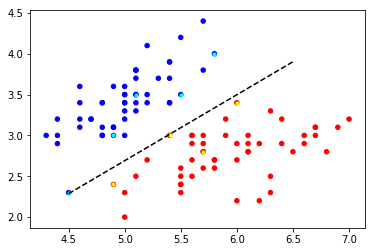

In [607]:
random.seed(2021)
np.random.seed(2021)

b,alphas=smoP2(dataArr, dataTags, C=0.94, toler=0.00001, maxIter=100)

print(b,alphas.shape)
alphas[alphas>0]

ws=calcWs(alphas, dataArr, dataTags)
#print(ws)

plot2(ws, b.tolist()[0][0])

## 使用径向基函数训练

In [633]:
b,alphas=smoP2(dataArr, dataTags, C=50, toler=0.00001, maxIter=40, kTup=['rbf', 1.5], debug=True)

print(b,alphas.shape)
alphas[alphas>0]

>>fullSet, iter:0 i:0, pairs changed:1
>>fullSet, iter:0 i:1, pairs changed:1
>>fullSet, iter:0 i:2, pairs changed:1
>>fullSet, iter:0 i:3, pairs changed:1
>>fullSet, iter:0 i:4, pairs changed:1
>>fullSet, iter:0 i:5, pairs changed:2
>>fullSet, iter:0 i:6, pairs changed:2
>>fullSet, iter:0 i:7, pairs changed:2
>>fullSet, iter:0 i:8, pairs changed:2
>>fullSet, iter:0 i:9, pairs changed:3
>>fullSet, iter:0 i:10, pairs changed:4
>>fullSet, iter:0 i:11, pairs changed:4
>>fullSet, iter:0 i:12, pairs changed:4
>>fullSet, iter:0 i:13, pairs changed:4
>>fullSet, iter:0 i:14, pairs changed:5
>>fullSet, iter:0 i:15, pairs changed:5
>>fullSet, iter:0 i:16, pairs changed:5
>>fullSet, iter:0 i:17, pairs changed:5
>>fullSet, iter:0 i:18, pairs changed:6
>>fullSet, iter:0 i:19, pairs changed:6
>>fullSet, iter:0 i:20, pairs changed:6
>>fullSet, iter:0 i:21, pairs changed:6
>>fullSet, iter:0 i:22, pairs changed:6
>>fullSet, iter:0 i:23, pairs changed:6
>>fullSet, iter:0 i:24, pairs changed:6
>>fullSet,

>>non-bound, iter:10 i:41, pairs changed:0
>>non-bound, iter:10 i:57, pairs changed:0
>>non-bound, iter:10 i:84, pairs changed:0
>>non-bound, iter:10 i:85, pairs changed:0
>>>> iteration number: 11
>>fullSet, iter:11 i:0, pairs changed:0
>>fullSet, iter:11 i:1, pairs changed:0
>>fullSet, iter:11 i:2, pairs changed:0
>>fullSet, iter:11 i:3, pairs changed:0
>>fullSet, iter:11 i:4, pairs changed:0
>>fullSet, iter:11 i:5, pairs changed:0
>>fullSet, iter:11 i:6, pairs changed:0
>>fullSet, iter:11 i:7, pairs changed:0
>>fullSet, iter:11 i:8, pairs changed:0
>>fullSet, iter:11 i:9, pairs changed:0
>>fullSet, iter:11 i:10, pairs changed:0
>>fullSet, iter:11 i:11, pairs changed:0
>>fullSet, iter:11 i:12, pairs changed:0
>>fullSet, iter:11 i:13, pairs changed:0
>>fullSet, iter:11 i:14, pairs changed:0
>>fullSet, iter:11 i:15, pairs changed:0
>>fullSet, iter:11 i:16, pairs changed:0
>>fullSet, iter:11 i:17, pairs changed:0
>>fullSet, iter:11 i:18, pairs changed:0
>>fullSet, iter:11 i:19, pairs ch

matrix([[ 0.8663508 ,  3.38306606, 12.3322466 ,  3.34124947, 23.95278476,
         33.99497602,  5.5293836 ,  4.35133807]])

[[11.84381451]
 [-5.27230791]] -1.4208054595815982


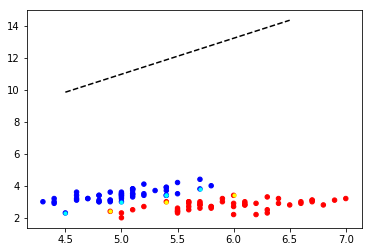

In [634]:
ws=calcWs(alphas, dataArr, dataTags)
#print(ws)

plot2(ws,b.tolist()[0][0])

> 核函数求的的分界面是不是不适合可视化？

## 测试集中使用核函数

In [635]:
print(iris.head())
iris.iloc[90:95,:]

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
1           5.1          3.5           1.4          0.2  setosa
2           4.9          3.0           1.4          0.2  setosa
3           4.7          3.2           1.3          0.2  setosa
4           4.6          3.1           1.5          0.2  setosa
5           5.0          3.6           1.4          0.2  setosa


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
91,5.5,2.6,4.4,1.2,versicolor
92,6.1,3.0,4.6,1.4,versicolor
93,5.8,2.6,4.0,1.2,versicolor
94,5.0,2.3,3.3,1.0,versicolor
95,5.6,2.7,4.2,1.3,versicolor


In [646]:
def testRbf(newX, alphas, w, b, dataArr, dataTags, ki=1.5):
    X=np.mat(dataArr)
    T=np.mat(dataTags).T
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=X[svInd]
    m,n=np.shape(X)

    # 核函数结果
    kerValue = kernelTrans(sVs, np.mat(newX), ['rbf', ki])
    #返回内积
    value = np.multiply(alphas[svInd], T[svInd]).T * kerValue+b
    return value

# test
testRbf([5.1,3.5], alphas, ws, b, dataArr, dataTags)

matrix([[-1.97370383]])

In [637]:
testRbf([5.6,	2.7], alphas, ws, b, dataArr, dataTags)

matrix([[2.13877273]])

In [645]:
# 分类效果很好：100%正确
correctCount=0
n=len(dataArr)
for i in range(n):
    pred=np.sign(testRbf(dataArr[i], alphas, ws, b, dataArr, dataTags) )
    real=dataTags[i]
    if pred==real:
        correctCount+=1
print(correctCount, n, round(correctCount/n*100,2),"%" )

100 100 100.0 %


### 测试不同的sigma参数

In [668]:
def testK(k2=1.5):
    b,alphas=smoP2(dataArr, dataTags, C=50, toler=0.00001, maxIter=40, kTup=['rbf', k2])
    ws=calcWs(alphas, dataArr, dataTags)
    
    # 分类效果很好：100%正确
    errorCount=0
    n=len(dataArr)
    for i in range(n):
        pred=np.sign(testRbf(dataArr[i], alphas, ws, b, dataArr, dataTags, ki=k2) )
        if pred!=dataTags[i]:
            errorCount+=1
    return round(errorCount/n*100,2)

# test
kernalParas=[0.1, 5, 10, 50, 100]
for i in range(len(kernalParas)):
    sigma=kernalParas[i]
    for j in range(10): #重复三次
        print('>>>> i=',i, "; sigma=",sigma, 'errorRate', testK(sigma))

>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 50.0
>>>> i= 1 ; sigma= 5 errorRate 3.0
>>>> i= 2 ; sigma= 10 errorRate 6.0
>>>> i= 2 ; sigma= 10 errorRate 50.0
>>>> i= 2 ; sigma= 10 errorRate 1.0
>>>> i= 2 ; sigma= 10 errorRate 50.0
>>>> i= 2 ; sigma= 10 errorRate 0.0
>>>> i= 2 ; sigma= 10 errorRate 50.0
>>>> i= 2 ; sigma= 10 errorRate 50.0
>>>> i= 2 ; sig

In [677]:
print(np.var( np.array(dataArr)[:,0] ))
np.var( np.array(dataArr)[:,1] )

0.40765900000000016


0.22689900000000005

> 貌似原始数据的var附近取值sigma，结果会比较稳定

In [679]:
# test
kernalParas=[0.1, 0.2, 0.3, 0.4, 0.5,0.6]
for i in range(len(kernalParas)):
    sigma=kernalParas[i]
    for j in range(10): #重复三次
        print('>>>> i=',i, "; sigma=",sigma, 'errorRate', testK(sigma))

>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 0 ; sigma= 0.1 errorRate 0.0
>>>> i= 1 ; sigma= 0.2 errorRate 0.0
>>>> i= 1 ; sigma= 0.2 errorRate 0.0
>>>> i= 1 ; sigma= 0.2 errorRate 28.0
>>>> i= 1 ; sigma= 0.2 errorRate 0.0
>>>> i= 1 ; sigma= 0.2 errorRate 28.0
>>>> i= 1 ; sigma= 0.2 errorRate 28.0
>>>> i= 1 ; sigma= 0.2 errorRate 0.0
>>>> i= 1 ; sigma= 0.2 errorRate 0.0
>>>> i= 1 ; sigma= 0.2 errorRate 0.0
>>>> i= 1 ; sigma= 0.2 errorRate 0.0
>>>> i= 2 ; sigma= 0.3 errorRate 45.0
>>>> i= 2 ; sigma= 0.3 errorRate 50.0
>>>> i= 2 ; sigma= 0.3 errorRate 45.0
>>>> i= 2 ; sigma= 0.3 errorRate 45.0
>>>> i= 2 ; sigma= 0.3 errorRate 50.0
>>>> i= 2 ; sigma= 0.3 errorRate 0.0
>>>> i= 2 ; sigma= 0.3 errorRa